# KilnDrone

The KilnDrone is a Raspberry Pi + Python based IoT kiln controller. With this software, a raspberry pi (even a raspberry pi zero!) and a little bit more hardware, a kiln can be programmed to maintain temperature across hours.

# Requirements

* [matplotlib](https://matplotlib.org/)

In [1]:
import asyncio
from time import sleep
from datetime import datetime
from dataclasses import dataclass, asdict
import multiprocessing
from queue import Empty
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Testing Harness

If this isn't a configured KilnDrone controller (i.e. a raspberry pi with the max31855 library present and the gpiozero library installed), stub those classes with mock versions to use in demonstration

In [2]:
try:
    from kilndrone import MAX31855
    from gpiozero import DigitalOutputDevice
except ImportError:
    print("Stubbing MAX31855 & Power")
    class MAX31855:
        stubbed = True
        temp = 0
        def getTemperature(self):
            self.temp += 1
            return self.temp

    class DigitalOutputDevice:
        stubbed = True
        def __init__(self, pin, initial_value):
            self.value = initial_value
        def on(self):
            self.value = True
        def off(self):
            self.value = False

Stubbing MAX31855 & Power


# SimpleQueue

SimpleQueue is used for management of data point memory in the controller object for a handful of concepts such as the controller's temperature or duty cycle.

In [3]:
class SimpleQueue:
    def __init__(self, depth):
        self.depth = depth
        self.queue = []

    def __getitem__(self, key):
        try:
            return self.queue[key]
        except:
            return None

    def __call__(self, value):
        self.queue.insert(0, value)
        while len(self.queue) > self.depth:
            self.queue.pop()

# KilnObservation

KilnObservation is the set of observations taken each cycle that are used for monitoring and next state calculations. This object defines a `__repr__` that is relied on as a fallback for communicating the kiln's state.

In [4]:
@dataclass
class KilnObservation:
    timestamp: str
    cycle: int
    temperature: float
    target: float
    power: float
    powerOn: bool
    setPower: float
    haltPowerChange: int
    powerStep: float
    slope: float
    accel: float
    cyclesUntilTarget: float
    error: float
    percentError: float
    realCycleTime: float
    lastTemperature: float

    def __repr__(self):
        reps = []
        for key, value in asdict(self).items():
            length = "10" if type(value) in [str, int, bool] else "10.8"
            reps.append("{key}: {value:<{length}}".format(key=key, value=value, length=length))
        return "Kiln=" + " | ".join(reps)

# KilnController

This object controls the hardware interfacing with the heating coils and temperature sensor of the kiln. By recording KilnObservations, KilnController determines if it should energize or depower the heating coils to achieve the desired `KilnController.targetTemp`

In [5]:
class KilnController:
    def __init__(self, targetQueue=None, stateQueue=None):
        self.maxPower = 70

        self.slopeBoost = 0.01
        self.accelBoost = 0.03
        
        self.cycleCount = 0
        self.cycleTime = 0.1
        self.realCycleTime = 1

        self.targetQueue = targetQueue
        try:
            self.targetTemp = self.targetQueue.get(block=False)
        except Empty:
            self.targetTemp = 0

        self.tempProbe = MAX31855()
    
        self.tempMemoryDepth = 60000
        self.tempMemory = SimpleQueue(self.tempMemoryDepth)
        self.tempMemory(self.temperature)
        
        self.setPower = 0
        self.setPowerMemory = SimpleQueue(60000)
        self.currentPower = 0
        self.powerWindow = 0.5

        self.power = DigitalOutputDevice(pin="GPIO17", initial_value=False)
        self.powerMemoryDepth = 60000
        self.powerOnMemory = SimpleQueue(self.powerMemoryDepth)
        self.powerMemory = SimpleQueue(self.powerMemoryDepth)
        
        self.restrictPowerChangeUntil = 0
        
        self.extendObservations(120)
        
        self.targetQueue = targetQueue
        self.stateQueue = stateQueue
    
    @property
    def filteredTemp(self):
        """Pass temperature readings from k-type sensors through 10-observation median filter"""
        window = 10
        fT = []
        for i in range(0, window ** 2, window):
            selected = sorted(self.tempMemory.queue[i:i + window])[int(window / 2)]
            fT.extend([selected for i in range(window)])
        return fT[:self.tempMemoryDepth]
    
    @property
    def temperature(self):
        """Recover temperature in fahrenheit from the k-type sensor"""
        return self.tempProbe.getTemperature()
    
    def getCurrentPower(self):
        """Calculate observed power duty cycle"""
        observationWindow = 1000
        return (sum(self.powerOnMemory.queue[:observationWindow]) / len(self.powerOnMemory.queue[:observationWindow])) * 100

    def observe(self):
        """Record state and sensor readings"""
        self.setPowerMemory(self.setPower)
        self.powerMemory(self.getCurrentPower())
        self.powerOnMemory(self.power.value)
        self.tempMemory(self.temperature)
    
    def extendObservations(self, n):
        """Fill in memory queues"""
        self.setPowerMemory.queue = [self.setPower for i in range(n)] + self.setPowerMemory.queue
        self.powerOnMemory.queue = [self.power.value for i in range(n)] + self.powerOnMemory.queue
        
        pMValue = self.getCurrentPower()
        self.powerMemory.queue = [pMValue for i in range(n)] + self.powerMemory.queue
        
        currentTemp = self.temperature
        self.tempMemory.queue = [currentTemp for i in range(n)] + self.tempMemory.queue

    def __processPower(self):
        """SHOULD NOT BE CALLED DIRECTLY
        
           Energize coils if observed power usage is under target usage and under max usage"""
        try:
            local = self.powerOnMemory[:10]
            tooMuchEnergy = (sum(local) / 10) * 100 > self.maxPower
            wantPower = self.getCurrentPower() < min(self.setPower, self.maxPower)
            
            if tooMuchEnergy:
                print("Too Much Energy")
                self.power.off()
            elif wantPower:
                print("Energizing")
                self.power.on()
            else:
                print("Depowering")
                self.power.off()
        except:
            print("ERROR!")
            self.power.off()
            raise
    
    def setTargetTemperature(self, targetTemperature):
        print(f"Setting target temperature to: {targetTemperature}")
        self.targetTemp = min(int(targetTemperature), 2300)
        self.restrictPowerChangeUntil = 0
        
    def characterizeKiln(self):
        """Build a KilnObservation from the kiln's state"""
        start = 0
        stop = 120
        obs = self.filteredTemp[start:stop]
        
        currentWindow = obs[:int(stop / 2)]
        secondWindow = obs[int(stop / 3):]

        temperature = currentWindow[0]
        error = self.targetTemp - temperature
        percentError = (error / (self.targetTemp if self.targetTemp != 0 else 1/10000)) * 100
        slope = (currentWindow[0] - currentWindow[-1]) / (len(currentWindow) * self.realCycleTime)
        secondWindowSlope = (secondWindow[0] - secondWindow[-1]) / (len(secondWindow) * self.realCycleTime)
        accel = (slope - secondWindowSlope) / 2
        if slope == 0 or (error * slope) < 0:
            cyclesUntilTarget = 99999
        else:
            cyclesUntilTarget = min(int(abs(error) / slope + 0.5), 99999)

            
        powerStep = min(max(25 * (error / 1500), 0.1), 5)

        state = KilnObservation(**{
            "timestamp": str(datetime.utcnow()),
            "cycle": self.cycleCount,
            "temperature": obs[0],
            "target": self.targetTemp,
            "power": self.getCurrentPower(),
            "powerOn": self.power.value,
            "setPower": self.setPower,
            "haltPowerChange": self.restrictPowerChangeUntil,
            "powerStep": powerStep,
            "slope": slope,
            "accel": accel,
            "cyclesUntilTarget": cyclesUntilTarget,
            "error": error,
            "percentError": percentError,
            "realCycleTime": self.realCycleTime,
            "lastTemperature": currentWindow[-1]
        })
        return state

    def tune(self):
        """Calculate the target power duty cycle"""
        if self.targetTemp < 80:
            print("Kiln Disabled")
            self.setPower = 0
            return

        kilnChar = self.characterizeKiln()
        print(f"Tuning: {kilnChar}")
        
        newPower = self.setPower
        if kilnChar.percentError < 0.01:
            print("Hard Power Cutoff")
            newPower = 0
        elif (kilnChar.error > 0 and kilnChar.cyclesUntilTarget < 15):
            print("Preemptively Cutting Power")
            newPower = 0
        elif (
            self.cycleCount > self.restrictPowerChangeUntil and 
            (kilnChar.slope <= self.slopeBoost or kilnChar.accel <= self.accelBoost)
        ):
            print("Adding Energy")
            newPower = max(kilnChar.power + kilnChar.powerStep, self.setPower + kilnChar.powerStep)
            self.restrictPowerChangeUntil = self.cycleCount + 15

        if self.setPower != newPower:
            self.setPower = max(min(newPower, self.maxPower), 0)
            print(f"Tuned power to {self.setPower}")
        else:
            print("Holding power constant")
    
    def reportState(self, state=None):
        """Push kiln's state onto message queue"""
        if self.stateQueue is None:
            return
        if state is None:
            state = self.characterizeKiln()
        self.stateQueue.put(state)
    
    def __repr__(self):
        return f"Kiln={self.characterizeKiln()}"

    def __cycle(self):
        """Cycle the kiln's operations. SHOULD NOT BE CALLED DIRECTLY
        
           This method may turn on the heating coils.
           Without successive calls, the heating coils may be left on...becoming a FIRE HAZARD
        """
        start = datetime.utcnow()
        if self.targetQueue is not None:
            try:
                self.setTargetTemperature(self.targetQueue.get(block=False))
            except Empty:
                pass

        self.cycleCount += 1
        self.observe()
        self.__processPower()
        if len(self.tempMemory.queue) > 120:
            state = self.tune()
            self.reportState(state)
            self.realCycleTime = (datetime.utcnow() - start).total_seconds()
    
    def run(self):
        while True:
            self.__cycle()
            sleep(self.cycleTime)

# KilnDrone

KilnDrone runs a KilnController and a visualization service asynchronously. This permits the KilnController to cycle its heating coils while a graph of the kiln's state is rendered.

In [12]:
class KilnDrone:
    def __init__(self):
        self.targetQueue = multiprocessing.Queue()
        self.stateQueue = multiprocessing.Queue()
        self.states = SimpleQueue(60000)
        self.controller = KilnController(targetQueue=self.targetQueue, stateQueue=self.stateQueue)
        self.cyclesBetweenRenders = 150
        self.renderWindow = 50
    
    def setTargetTemperature(self, temperature):
        assert type(float(temperature)) == float
        self.targetQueue.put(temperature)  

    async def monitor(self, render=False):
        """Pull the kiln's state off the message queue, store and optionally render"""
        state = self.stateQueue.get()
        self.states(state)
        if render:
            if state.cycle > self.renderWindow:
                self.renderWindow = state.cycle + self.cyclesBetweenRenders
                self.renderKilnDrone(displayFigure=render)
            elif state.cycle % 10 == 0:
                print(f"Observer will start rendering in {self.renderWindow - state.cycle} cycles")
                
    def syncMonitor(self, render=False):
        """Synchronously, forever -- Pull the kiln's state off the message queue, store and optionally render"""
        while True:
            state = self.stateQueue.get()
            self.states(state)
            if render:
                if state.cycle > self.renderWindow:
                    self.renderWindow = state.cycle + self.cyclesBetweenRenders
                    self.renderKilnDrone(displayFigure=render)
                elif state.cycle % 10 == 0:
                    print(f"Observer will start rendering in {self.renderWindow - state.cycle} cycles")

    def renderKilnDrone(self, cyclesAgo=6000, renderPowerImpluse=True, displayFigure=False):
        """Create a graph of the past kiln states"""
        print("Observer Rendering KilnDrone")
        temperature = [s.temperature for s in self.states[:cyclesAgo]]
        targetTemperature = [s.target for s in self.states[:cyclesAgo]]
        setPower = [s.setPower for s in self.states[:cyclesAgo]]
        power = [s.power for s in self.states[:cyclesAgo]]
        powerImpulse = [s.powerOn * s.setPower for s in self.states[:cyclesAgo]]

        fig, ax = plt.subplots()
        ax.set_xlabel("Cycles Ago")
        ax2 = ax.twinx()
        ax.set_ylabel("Temperature (*F)")

        ln1 = ax.plot(temperature, color="green", label="Temperature", zorder=8)
        ln2 = ax.plot(targetTemperature, color="blue", label="Target Temperature", zorder=7)

        if renderPowerImpluse:
            ln3 = ax2.plot(powerImpulse, color="darkred", label="Power Impulse", zorder=4)

        ln4 = ax2.plot(setPower, color="pink", label="Set Power", zorder=5)
        ln5 = ax2.plot(power, color="turquoise", label="Power", zorder=6)

        ax2.set_ylabel("Power Duty Cycle")
        lines = ln1 + ln2 + ln4 + ln5
        if renderPowerImpluse:
            lines = lines + ln3
        labels = [l.get_label() for l in lines]
        ax.legend(lines, labels, loc="upper right").set_zorder(100)
        plt.title("Temperature and Power over Time")
        ax.set_zorder(ax2.get_zorder() + 1)
        ax.patch.set_visible(False)
        if displayFigure:
            display(plt.show())
        return fig
    
    def multiProcRun(self, target=None):
        """Create subprocesses for the controller and renderer and start them"""
        if target is not None:
            self.setTargetTemperature(target)
        
        controllerProc = multiprocessing.Process(target=self.controller.run)
        monitorProc = multiprocessing.Process(target=self.syncMonitor, kwargs={"render": True})
        
        try:
            print("Starting kiln processes")
            controllerProc.start()
            monitorProc.start()
            controllerProc.join()
        except:
            print("Killing processes")
            controllerProc.terminate()
            monitorProc.terminate()
        finally:
            print("Setting heater power to off")
            self.controller.power.off()
    
    async def asyncRun(self):
        """asyncio entry point for running KilnDrone"""
        while True:
            await asyncio.sleep(self.controller.cycleTime)
            self.controller.cycle()
            await self.monitor()

Starting kiln processes
Setting target temperature to: 100
Depowering
Tuning: Kiln=timestamp: 2021-10-13 03:38:37.092295 | cycle: 1          | temperature: 2          | target: 100        | power: 0.0        | powerOn: 0          | setPower: 0          | haltPowerChange: 0          | powerStep: 1.6333333  | slope: 0.0        | accel: 0.0        | cyclesUntilTarget: 99999      | error: 98         | percentError: 98.0       | realCycleTime: 1          | lastTemperature: 2         
Adding Energy
Tuned power to 1.633333333333333
Energizing
Tuning: Kiln=timestamp: 2021-10-13 03:38:37.198855 | cycle: 2          | temperature: 2          | target: 100        | power: 0.0        | powerOn: 1          | setPower: 1.6333333  | haltPowerChange: 16         | powerStep: 1.6333333  | slope: 0.0        | accel: 0.0        | cyclesUntilTarget: 99999      | error: 98         | percentError: 98.0       | realCycleTime: 0.009602   | lastTemperature: 2         
Holding power constant
Energizing
Tuning: Ki

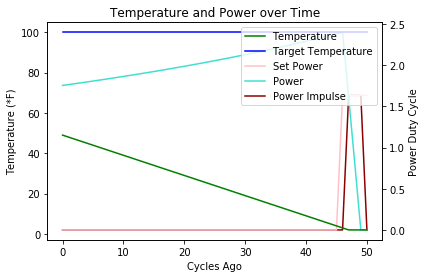

None

Depowering
Tuning: Kiln=timestamp: 2021-10-13 03:38:42.635297 | cycle: 53         | temperature: 51         | target: 100        | power: 1.734104   | powerOn: 0          | setPower: 0          | haltPowerChange: 16         | powerStep: 0.81666667 | slope: 115.78997  | accel: 47.261213  | cyclesUntilTarget: 0          | error: 49         | percentError: 49.0       | realCycleTime: 0.007053   | lastTemperature: 2         
Preemptively Cutting Power
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-13 03:38:42.741156 | cycle: 54         | temperature: 52         | target: 100        | power: 1.7241379  | powerOn: 0          | setPower: 0          | haltPowerChange: 16         | powerStep: 0.8        | slope: 147.59712  | accel: 59.038848  | cyclesUntilTarget: 0          | error: 48         | percentError: 48.0       | realCycleTime: 0.005646   | lastTemperature: 2         
Preemptively Cutting Power
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-13 03:3

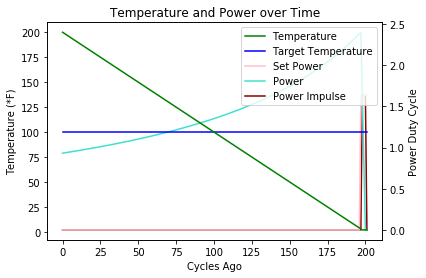

None

Depowering
Tuning: Kiln=timestamp: 2021-10-13 03:38:58.744900 | cycle: 204        | temperature: 202        | target: 100        | power: 0.92592593 | powerOn: 0          | setPower: 0          | haltPowerChange: 16         | powerStep: 0.1        | slope: 113.96791  | accel: 0.0        | cyclesUntilTarget: 99999      | error: -102       | percentError: -102.0     | realCycleTime: 0.007312   | lastTemperature: 152       
Hard Power Cutoff
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-13 03:38:58.852018 | cycle: 205        | temperature: 203        | target: 100        | power: 0.92307692 | powerOn: 0          | setPower: 0          | haltPowerChange: 16         | powerStep: 0.1        | slope: 117.78563  | accel: 0.0        | cyclesUntilTarget: 99999      | error: -103       | percentError: -103.0     | realCycleTime: 0.007075   | lastTemperature: 153       
Hard Power Cutoff
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-13 03:38:58.958864 | cycl

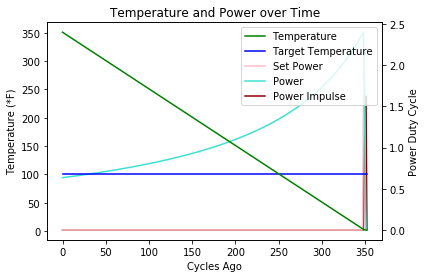

None

Depowering
Tuning: Kiln=timestamp: 2021-10-13 03:39:14.879207 | cycle: 355        | temperature: 353        | target: 100        | power: 0.63157895 | powerOn: 0          | setPower: 0          | haltPowerChange: 16         | powerStep: 0.1        | slope: 112.43029  | accel: 0.0        | cyclesUntilTarget: 99999      | error: -253       | percentError: -253.0     | realCycleTime: 0.007412   | lastTemperature: 303       
Hard Power Cutoff
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-13 03:39:14.986463 | cycle: 356        | temperature: 354        | target: 100        | power: 0.6302521  | powerOn: 0          | setPower: 0          | haltPowerChange: 16         | powerStep: 0.1        | slope: 115.35622  | accel: 0.0        | cyclesUntilTarget: 99999      | error: -254       | percentError: -254.0     | realCycleTime: 0.007224   | lastTemperature: 304       
Hard Power Cutoff
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-13 03:39:15.093207 | cycl

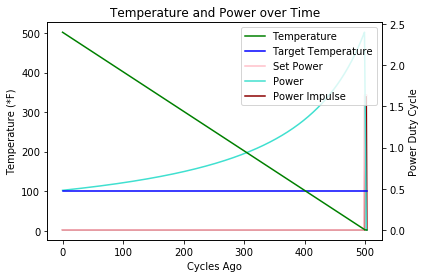

None

Depowering
Tuning: Kiln=timestamp: 2021-10-13 03:39:31.014625 | cycle: 506        | temperature: 504        | target: 100        | power: 0.47923323 | powerOn: 0          | setPower: 0          | haltPowerChange: 16         | powerStep: 0.1        | slope: 116.2088   | accel: 0.0        | cyclesUntilTarget: 99999      | error: -404       | percentError: -404.0     | realCycleTime: 0.007171   | lastTemperature: 454       
Hard Power Cutoff
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-13 03:39:31.121769 | cycle: 507        | temperature: 505        | target: 100        | power: 0.4784689  | powerOn: 0          | setPower: 0          | haltPowerChange: 16         | powerStep: 0.1        | slope: 119.23499  | accel: 0.0        | cyclesUntilTarget: 99999      | error: -405       | percentError: -405.0     | realCycleTime: 0.006989   | lastTemperature: 455       
Hard Power Cutoff
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-13 03:39:31.228430 | cycl

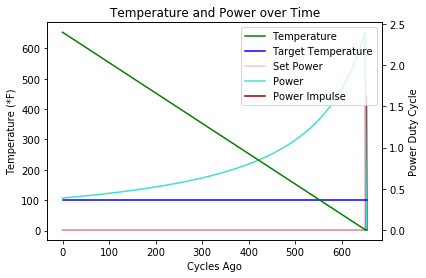

None

Depowering
Tuning: Kiln=timestamp: 2021-10-13 03:39:47.150334 | cycle: 657        | temperature: 655        | target: 100        | power: 0.38610039 | powerOn: 0          | setPower: 0          | haltPowerChange: 16         | powerStep: 0.1        | slope: 115.02185  | accel: 0.0        | cyclesUntilTarget: 99999      | error: -555       | percentError: -555.0     | realCycleTime: 0.007245   | lastTemperature: 605       
Hard Power Cutoff
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-13 03:39:47.256829 | cycle: 658        | temperature: 656        | target: 100        | power: 0.38560411 | powerOn: 0          | setPower: 0          | haltPowerChange: 16         | powerStep: 0.1        | slope: 130.69845  | accel: 0.0        | cyclesUntilTarget: 99999      | error: -556       | percentError: -556.0     | realCycleTime: 0.006376   | lastTemperature: 606       
Hard Power Cutoff
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-13 03:39:47.363558 | cycl

In [13]:
if __name__ == "__main__":
    k = KilnDrone()
    k.multiProcRun(target=100)